<a href="https://colab.research.google.com/github/Joao-Miranda-jvcm/Joao-Miranda-jvcm/blob/master/Conhe%C3%A7a_o_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from google.colab import files
uploaded = files.upload()

Saving Dolar.csv to Dolar.csv


In [13]:
df = pd.read_csv(list(uploaded.keys())[0],sep=';')
df.head()

df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df['Valor'] = df['Valor'].str.replace(',', '.').astype(float)
scaler = MinMaxScaler(feature_range=(0, 1))
df_close = scaler.fit_transform(df['Valor'].values.reshape(-1, 1))

In [58]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 50
X, y = create_sequences(df_close, seq_length)

In [59]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

In [60]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [66]:
input_size = 1
hidden_size = 512
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [67]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [68]:

train_data = StockDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=50, shuffle=True)


num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for sequences, labels in train_loader:
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 1/100, Loss: 0.2356
Epoch 2/100, Loss: 0.0697
Epoch 3/100, Loss: 0.0855
Epoch 4/100, Loss: 0.0416
Epoch 5/100, Loss: 0.0423
Epoch 6/100, Loss: 0.0331
Epoch 7/100, Loss: 0.0309
Epoch 8/100, Loss: 0.0193
Epoch 9/100, Loss: 0.0149
Epoch 10/100, Loss: 0.0074
Epoch 11/100, Loss: 0.0081
Epoch 12/100, Loss: 0.0091
Epoch 13/100, Loss: 0.0088
Epoch 14/100, Loss: 0.0047
Epoch 15/100, Loss: 0.0040
Epoch 16/100, Loss: 0.0049
Epoch 17/100, Loss: 0.0043
Epoch 18/100, Loss: 0.0062
Epoch 19/100, Loss: 0.0049
Epoch 20/100, Loss: 0.0051
Epoch 21/100, Loss: 0.0041
Epoch 22/100, Loss: 0.0063
Epoch 23/100, Loss: 0.0047
Epoch 24/100, Loss: 0.0056
Epoch 25/100, Loss: 0.0081
Epoch 26/100, Loss: 0.0024
Epoch 27/100, Loss: 0.0045
Epoch 28/100, Loss: 0.0028
Epoch 29/100, Loss: 0.0035
Epoch 30/100, Loss: 0.0071
Epoch 31/100, Loss: 0.0029
Epoch 32/100, Loss: 0.0046
Epoch 33/100, Loss: 0.0032
Epoch 34/100, Loss: 0.0042
Epoch 35/100, Loss: 0.0023
Epoch 36/100, Loss: 0.0026
Epoch 37/100, Loss: 0.0035
Epoch 38/1

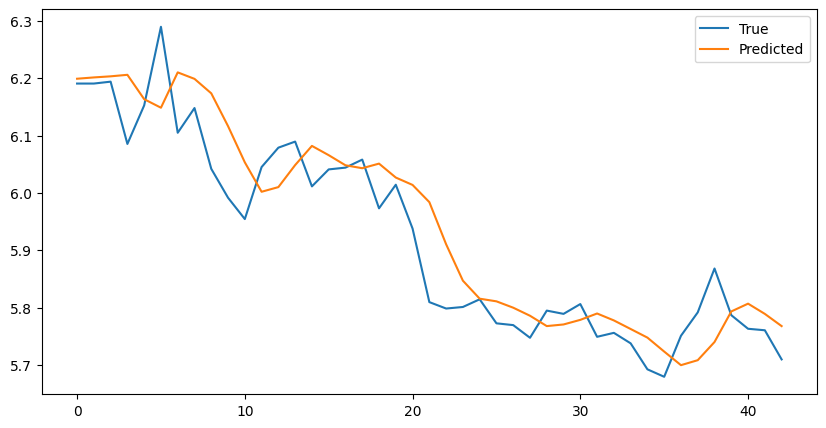

In [69]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = predictions.detach().numpy()
    predictions = scaler.inverse_transform(predictions)
    y_test = y_test_tensor.numpy()
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("MSE:", mse)
print("MAE:", mae)

MSE: 0.0048363590613007545
MAE: 0.05455998331308365
